In [2]:
import os
os.chdir('C://Users//saika//Downloads//Assembly_paper')

import numpy as np
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
from tqdm import tqdm
import pandas as pd
from lsmm_data import LSMMData
import json

with open('v1dd_data_structures_information.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
data_a = my_data.data
params_a = my_data.params
dirs_a = my_data.dirs
mappings_a = my_data.mappings

c:\Users\saika\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\saika\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\saika\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Generating Connectome...


100%|██████████| 137706/137706 [02:37<00:00, 873.35it/s]


Generating Connectome...


100%|██████████| 137706/137706 [03:37<00:00, 634.48it/s] 


In [3]:
cell_table = data_a['structural']['pre_cell'].copy()
cell_table['connectome_index'] = cell_table.index
synapse_table = data_a['structural']['synapse']
adjacency_matrix = data_a['structural']['binary_connectome']
summed_size_connectome = data_a['structural']['summed_size_connectome']
# Convert connectome indices to pt_root_ids
index_to_root_id = [mappings_a['connectome_index_to_root_id'][i] for i in range(adjacency_matrix.shape[0])]

# Convert summed_size_connectome to a DataFrame using pt_root_ids as row and column labels
summed_size_connectome_df = pd.DataFrame(
    summed_size_connectome,
    index=index_to_root_id,
    columns=index_to_root_id
)

# Create a directed graph with pt_root_ids as node labels
pyr_graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

# Relabel nodes to use pt_root_ids instead of numerical indices
pyr_graph = nx.relabel_nodes(pyr_graph, {i: index_to_root_id[i] for i in range(len(index_to_root_id))})

# Motif Analysis with DotMotif: 2 Chain, All Pyr
executor = GrandIsoExecutor(graph=pyr_graph)
chain_defs = Motif("""
                A -> B
                B -> C 
              """)

chain_results = executor.find(chain_defs)

two_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])

# each assembly with each pt_root_id within 
assembly_to_root_ids = mappings_a['pt_root_ids_by_assembly']
# set of all root_ids with assembly membership status
assembly_root_ids_set = set(mappings_a['assemblies_by_pt_root_id'].keys())

# get set of all root ids for square matrix
coregistered_cell_table = cell_table[cell_table['pt_root_id'].isin(assembly_root_ids_set)]
coregistered_root_ids = set(coregistered_cell_table['pt_root_id'].values)  # Coregistered cells only (pyramidal)

# filter synapses_df to only coregistered cells
synapses_df = synapse_table[synapse_table['pre_pt_root_id'].isin(assembly_root_ids_set)]
synapses_df = synapses_df[synapses_df['post_pt_root_id'].isin(assembly_root_ids_set)]

# Get the assemblies each root_id belongs in and the list of root_ids without an assembly
assembly_names = set(assembly_to_root_ids.keys()) - set(['No A'])
A_invert = {assembly: set(assembly_to_root_ids[assembly]) for assembly in assembly_names}
no_A = set(assembly_to_root_ids['No A'])
A = {pt_root_id: set(mappings_a['assemblies_by_pt_root_id'][pt_root_id]) for pt_root_id in coregistered_root_ids if 'No A' not in mappings_a['assemblies_by_pt_root_id'][pt_root_id]}

100%|██████████| 6052393/6052393 [00:04<00:00, 1214566.48it/s]


In [4]:
def shared(pre, post, A):
    try:
        return not A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def disjoint(pre, post, A):
    try:
        return A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def shared_no_a(pre, post, A):
    return (pre in no_A) and (post in no_A)
    
def no_a_a(pre, post, A):
    return (pre in no_A) and (post not in no_A)

def a_no_a(pre, post, A):
    return (pre not in no_A) and (post in no_A)

C = [shared, disjoint, shared_no_a, no_a_a, a_no_a]

In [5]:
# Initialize dictionaries to store weights and binary connectivity
W_excitatory = {}
W_inhibitory = {}
B_excitatory = {}
B_inhibitory = {}

# Define all potential (pre-cell, post-cell) pairs with excitatory and inhibitory chain types
for j in coregistered_root_ids:
    for i in coregistered_root_ids:
        if j != i:  # Exclude autapses
            W_excitatory[(j, i)] = 0
            W_inhibitory[(j, i)] = 0
            B_excitatory[(j, i)] = 0
            B_inhibitory[(j, i)] = 0

pt_root_id_to_classification = cell_table.set_index('pt_root_id')['classification_system'].to_dict()

# Process each row in `two_chain_results_array` to populate weights and binary connectivity
for _, row in enumerate(two_chain_results_array):
    pre_cell, mid_cell, post_cell = row  # j: pre-cell, k: middle cell, i: post-cell
    if pre_cell in coregistered_root_ids and post_cell in coregistered_root_ids:
    # Determine chain type (excitatory if middle cell is in excitatory set, else inhibitory)
        if pt_root_id_to_classification[mid_cell] == 'inhibitory':
            W_chain = W_inhibitory
            B_chain = B_inhibitory
        elif pt_root_id_to_classification[mid_cell] == 'excitatory':
            W_chain = W_excitatory
            B_chain = B_excitatory
    # Get synapse weights for connections j -> k and k -> i
        w_jk = summed_size_connectome_df.loc[pre_cell, mid_cell]
        w_ki = summed_size_connectome_df.loc[mid_cell, post_cell]
    
    # Updates weights and binary connectivity
        W_chain[(pre_cell, post_cell)] += (w_jk * w_ki)
        B_chain[(pre_cell, post_cell)] = 1

In [6]:
# Aggregate nonzero pairs and calculate connectivity probabilities by connection type
W_nonzero_pair_excitatory = {}
W_nonzero_pair_inhibitory = {}
B_pair_excitatory = {}
B_pair_inhibitory = {}

for connection_type in C:
    # Initialize dictionaries per connection type
    W_nonzero_pair_excitatory[connection_type.__name__] = {}
    W_nonzero_pair_inhibitory[connection_type.__name__] = {}
    B_pair_excitatory[connection_type.__name__] = {}
    B_pair_inhibitory[connection_type.__name__] = {}

    # Process all (j, i) pairs from excitatory/inhibitory dictionaries
    for (j, i) in W_excitatory.keys():
        if connection_type(j, i, A):
            # Set binary connectivity for each connection type
            B_pair_excitatory[connection_type.__name__][(j, i)] = 1 if W_excitatory[(j, i)] > 0 else 0
            B_pair_inhibitory[connection_type.__name__][(j, i)] = 1 if W_inhibitory[(j, i)] > 0 else 0
            
            # Store only nonzero weights
            if W_excitatory[(j, i)] > 0:
                W_nonzero_pair_excitatory[connection_type.__name__][(j, i)] = W_excitatory[(j, i)]
            if W_inhibitory[(j, i)] > 0:
                W_nonzero_pair_inhibitory[connection_type.__name__][(j, i)] = W_inhibitory[(j, i)]

# Aggregate chain weights and connectivity for outbound and inbound paths
W_nonzero_chain_out_excitatory = {}
W_nonzero_chain_out_inhibitory = {}
W_nonzero_chain_in_excitatory = {}
W_nonzero_chain_in_inhibitory = {}
B_chain_out = {}
B_chain_in = {}
B_chain_out_excitatory = {}
B_chain_out_inhibitory = {}
B_chain_in_excitatory = {}
B_chain_in_inhibitory = {}

# Iterate through connection types in C (e.g., shared, disjoint)
for connection_type in C:
    # Initialize per connection type dictionaries
    W_nonzero_chain_out_excitatory[connection_type.__name__] = {}
    W_nonzero_chain_out_inhibitory[connection_type.__name__] = {}
    W_nonzero_chain_in_excitatory[connection_type.__name__] = {}
    W_nonzero_chain_in_inhibitory[connection_type.__name__] = {}
    B_chain_out[connection_type.__name__] = {}
    B_chain_in[connection_type.__name__] = {}
    B_chain_out_excitatory[connection_type.__name__] = {}
    B_chain_out_inhibitory[connection_type.__name__] = {}
    B_chain_in_excitatory[connection_type.__name__] = {}
    B_chain_in_inhibitory[connection_type.__name__] = {}
    # Outbound analysis (from pre-cell j to post-cell i through middle cell k)
    for j in coregistered_root_ids:
        potential_partners_out = {i for i in coregistered_root_ids if i != j and connection_type(j, i, A)}
        if potential_partners_out:  # Only proceed if valid post-cell partners exist
            realized_chains_count_excitatory = 0
            realized_chains_count_inhibitory = 0
            sum_weights_excitatory = 0
            sum_weights_inhibitory = 0

            for i in potential_partners_out:
                temporary_chain_results = two_chain_results_array[(two_chain_results_array[:, 0] == j) & (two_chain_results_array[:, 2] == i)]

                for chain in temporary_chain_results:
                    j, k, i = chain
                    w_jk = summed_size_connectome_df.loc[j, k]
                    w_ki = summed_size_connectome_df.loc[k, i]
                    # Check chain type and accumulate only when both segments have valid weights
                    if pt_root_id_to_classification.get(k) == 'excitatory':
                        sum_weights_excitatory += w_jk * w_ki
                        realized_chains_count_excitatory += 1  # Increase excitatory chain count
                    elif pt_root_id_to_classification.get(k) == 'inhibitory':
                        sum_weights_inhibitory += w_jk * w_ki
                        realized_chains_count_inhibitory += 1  # Increase inhibitory chain count

            # Normalize weights by realized chain count only if nonzero
            if realized_chains_count_excitatory > 0:
                W_nonzero_chain_out_excitatory[connection_type.__name__][j] = sum_weights_excitatory / realized_chains_count_excitatory
            if realized_chains_count_inhibitory > 0:
                W_nonzero_chain_out_inhibitory[connection_type.__name__][j] = sum_weights_inhibitory / realized_chains_count_inhibitory

            # Calculate binary connectivity only if there are potential partners
            B_chain_out[connection_type.__name__][j] = (
                (realized_chains_count_excitatory + realized_chains_count_inhibitory) / len(potential_partners_out)
                if len(potential_partners_out) > 0 else 0
                )
            B_chain_out_excitatory[connection_type.__name__][j] = realized_chains_count_excitatory / len(potential_partners_out) if len(potential_partners_out) > 0 else 0
            B_chain_out_inhibitory[connection_type.__name__][j] = realized_chains_count_inhibitory / len(potential_partners_out) if len(potential_partners_out) > 0 else 0
    
    for i in coregistered_root_ids:
        potential_partners_in = {j for j in coregistered_root_ids if i != j and connection_type(j, i, A)}
        if potential_partners_in:  # Only proceed if valid post-cell partners exist
            realized_chains_count_excitatory = 0
            realized_chains_count_inhibitory = 0
            sum_weights_excitatory = 0
            sum_weights_inhibitory = 0

            for j in potential_partners_in:
                temporary_chain_results = two_chain_results_array[(two_chain_results_array[:, 0] == j) & (two_chain_results_array[:, 2] == i)]

                for chain in temporary_chain_results:
                    j, k, i = chain
                    w_jk = summed_size_connectome_df.loc[j, k]
                    w_ki = summed_size_connectome_df.loc[k, i]
                    # Check chain type and accumulate only when both segments have valid weights
                    if pt_root_id_to_classification.get(k) == 'excitatory':
                        sum_weights_excitatory += w_jk * w_ki
                        realized_chains_count_excitatory += 1  # Increase excitatory chain count
                    elif pt_root_id_to_classification.get(k) == 'inhibitory':
                        sum_weights_inhibitory += w_jk * w_ki
                        realized_chains_count_inhibitory += 1  # Increase inhibitory chain count

            # Normalize weights by realized chain count only if nonzero
            if realized_chains_count_excitatory > 0:
                W_nonzero_chain_in_excitatory[connection_type.__name__][i] = sum_weights_excitatory / realized_chains_count_excitatory
            if realized_chains_count_inhibitory > 0:
                W_nonzero_chain_in_inhibitory[connection_type.__name__][i] = sum_weights_inhibitory / realized_chains_count_inhibitory

            # Calculate binary connectivity only if there are potential partners
            B_chain_in[connection_type.__name__][j] = (
                (realized_chains_count_excitatory + realized_chains_count_inhibitory) / len(potential_partners_in)
                if len(potential_partners_in) > 0 else 0
            )
            B_chain_in_excitatory[connection_type.__name__][i] = realized_chains_count_excitatory / len(potential_partners_in) if len(potential_partners_in) > 0 else 0
            B_chain_in_inhibitory[connection_type.__name__][i] = realized_chains_count_inhibitory / len(potential_partners_in) if len(potential_partners_in) > 0 else 0

# Pairwise: Shared v Disjoint 

# Probability of Connection: Chi-Squared Test of Independence

In [7]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns


def chi_squared_analysis(data):
    """
    Perform a chi-squared test of independence on a contingency table, visualize observed and expected values,
    and display the chi-squared test statistic, degrees of freedom, and p-value.

    Parameters:
    data (pd.DataFrame): A DataFrame representing the contingency table.

    """
    # Perform the chi-squared test
    chi2, p, dof, expected = stats.chi2_contingency(data)

    # Convert expected values to DataFrame for easy visualization
    expected_df = pd.DataFrame(expected, index=data.index, columns=data.columns)

    # Plot observed and expected values side by side
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.heatmap(data, annot=True, fmt=".0f", cmap="Blues", ax=axes[0])
    axes[0].set_title("Observed Values")

    sns.heatmap(expected_df, annot=True, fmt=".2f", cmap="Reds", ax=axes[1])
    axes[1].set_title("Expected Values")

    plt.tight_layout()
    plt.show()

    # Display the chi-squared test results
    print(f"Chi-squared Statistic: {chi2:.2f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"P-value: {p:.4f}")

Excitatory Chain Contingency Table:
          Connected  Not Connected
Shared          125            569
Disjoint        191            921


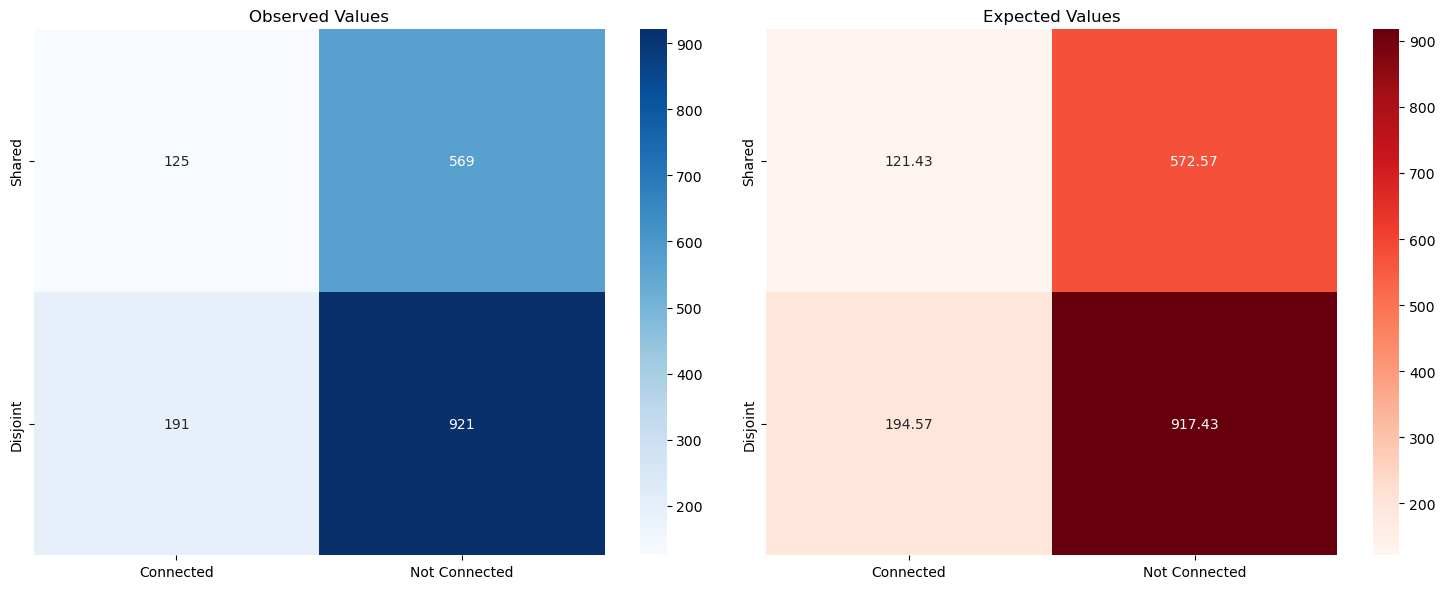

Chi-squared Statistic: 0.15
Degrees of Freedom: 1
P-value: 0.6960

Inhibitory Chain Contingency Table:
          Connected  Not Connected
Shared          694              0
Disjoint       1111              1


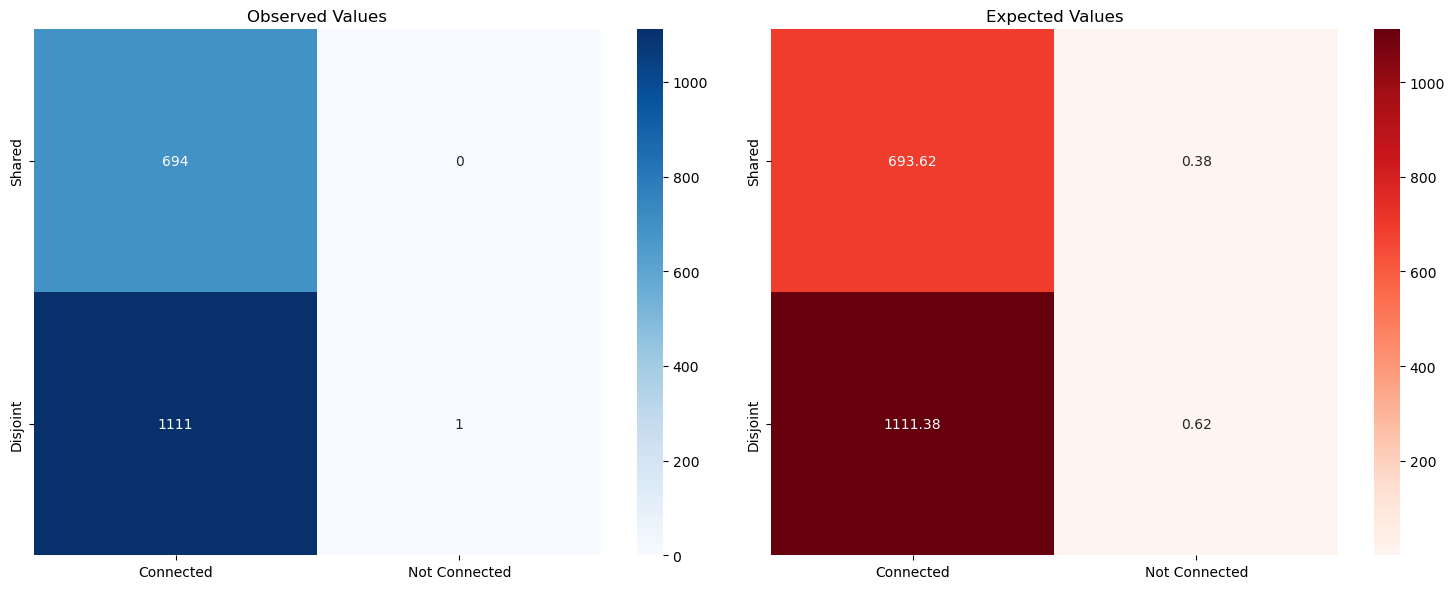

Chi-squared Statistic: 0.00
Degrees of Freedom: 1
P-value: 1.0000


In [8]:
excitatory_shared_connected = sum(1 for pair, val in B_pair_excitatory['shared'].items() if val == 1)
excitatory_shared_not_connected = sum(1 for pair, val in B_pair_excitatory['shared'].items() if val == 0)
excitatory_disjoint_connected = sum(1 for pair, val in B_pair_excitatory['disjoint'].items() if val == 1)
excitatory_disjoint_not_connected = sum(1 for pair, val in B_pair_excitatory['disjoint'].items() if val == 0)

excitatory_contingency_table = pd.DataFrame({
    'Connected': [excitatory_shared_connected, excitatory_disjoint_connected],
    'Not Connected': [excitatory_shared_not_connected, excitatory_disjoint_not_connected]
}, index=['Shared', 'Disjoint'])

print("Excitatory Chain Contingency Table:")
print(excitatory_contingency_table)
chi_squared_analysis(excitatory_contingency_table)  # Perform chi-squared analysis for excitatory chains

# Inhibitory Chain Contingency Table
inhibitory_shared_connected = sum(1 for pair, val in B_pair_inhibitory['shared'].items() if val == 1)
inhibitory_shared_not_connected = sum(1 for pair, val in B_pair_inhibitory['shared'].items() if val == 0)
inhibitory_disjoint_connected = sum(1 for pair, val in B_pair_inhibitory['disjoint'].items() if val == 1)
inhibitory_disjoint_not_connected = sum(1 for pair, val in B_pair_inhibitory['disjoint'].items() if val == 0)

inhibitory_contingency_table = pd.DataFrame({
    'Connected': [inhibitory_shared_connected, inhibitory_disjoint_connected],
    'Not Connected': [inhibitory_shared_not_connected, inhibitory_disjoint_not_connected]
}, index=['Shared', 'Disjoint'])

print("\nInhibitory Chain Contingency Table:")
print(inhibitory_contingency_table)
chi_squared_analysis(inhibitory_contingency_table)  # Perform chi-squared analysis for inhibitory chains

# Nonzero Combined Post-Synaptic Densities: Rank-Sum

Excitatory Chain


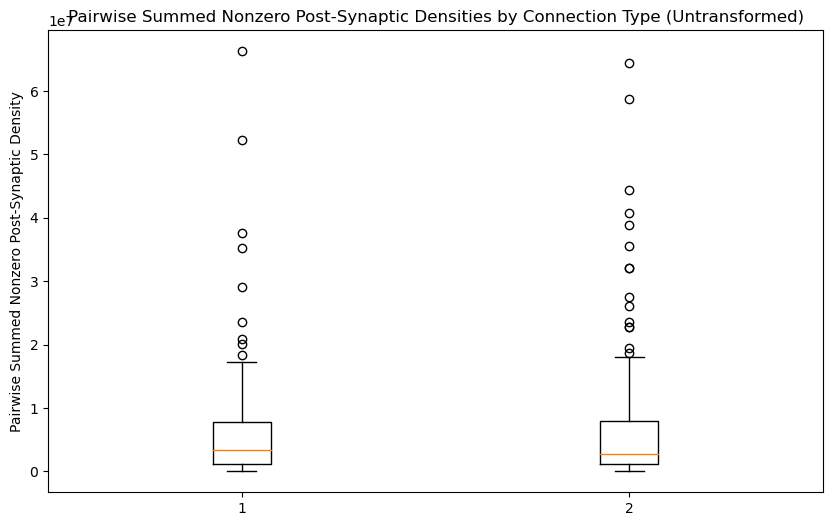

Wilcoxon Rank-Sum Test (Untransformed Data)
Greater Test Statistic: 0.33935017017127955 p-value: 0.3671729760587428
Lesser Test Statistic: 0.33935017017127955 p-value: 0.6328270239412572


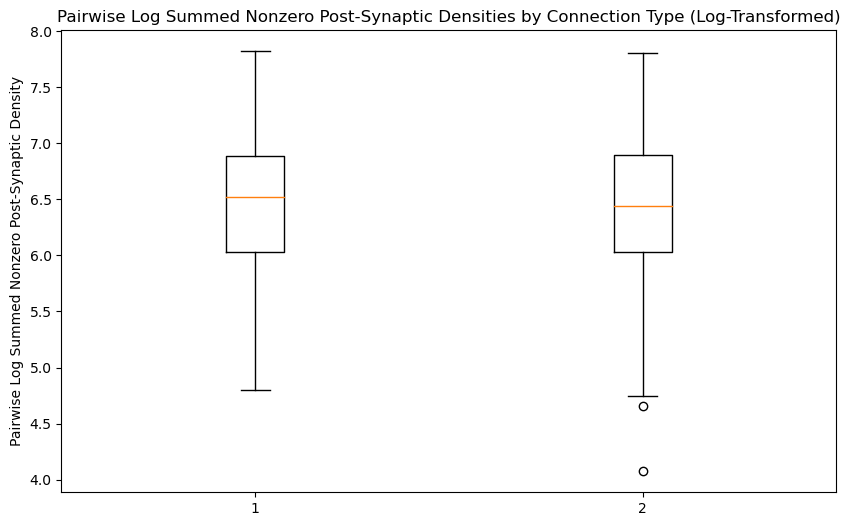


Levene's Test for Equal Variance (Log-Transformed Data)
Test Statistic: 0.5955326518974424 p-value: 0.44086798949279393

Independent T-Test (Log-Transformed Data)
Greater Test Statistic: 0.5479746606295115 p-value: 0.29204931601914536
Lesser Test Statistic: 0.5479746606295115 p-value: 0.7079506839808547
Inhibitory Chain


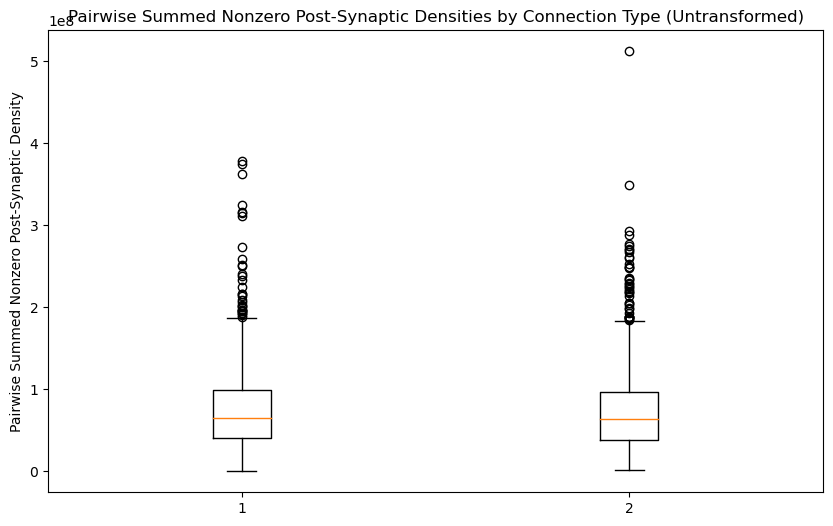

Wilcoxon Rank-Sum Test (Untransformed Data)
Greater Test Statistic: 0.8204440741440422 p-value: 0.2059814993562335
Lesser Test Statistic: 0.8204440741440422 p-value: 0.7940185006437666


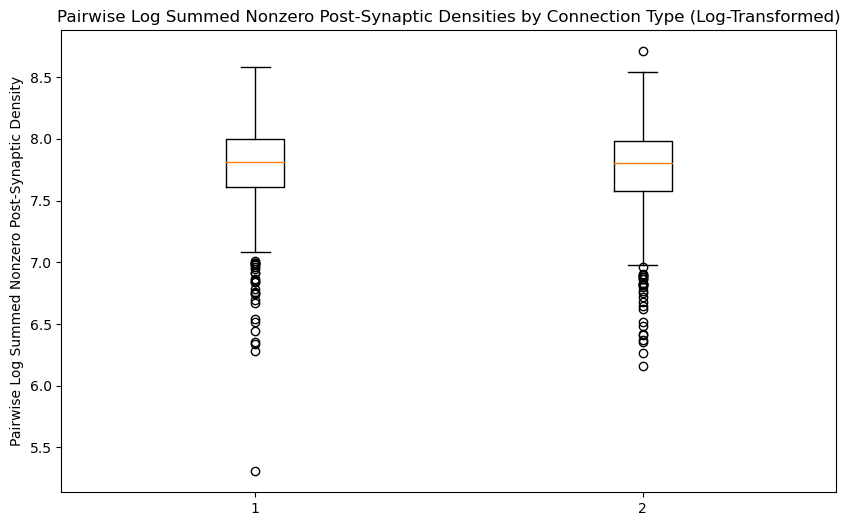


Levene's Test for Equal Variance (Log-Transformed Data)
Test Statistic: 0.019228360446431534 p-value: 0.8897292844151345

Independent T-Test (Log-Transformed Data)
Greater Test Statistic: 0.49724227845813135 p-value: 0.3095394197095538
Lesser Test Statistic: 0.49724227845813135 p-value: 0.6904605802904462


In [10]:
from scipy.stats import ttest_ind, levene, ranksums, wilcoxon

def compare_summed_psds(W_nonzero_pair):
    """
    Compare pairwise summed nonzero post-synaptic densities by connection type (Shared vs Disjoint).
    Performs Wilcoxon rank-sum test on untransformed data and an independent t-test on log-transformed data.
    Generates box plots for each test and outputs test statistics and p-values.
    
    Parameters:
    W_nonzero_pair (dict): Dictionary with keys 'shared' and 'disjoint' mapping to pairwise summed PSD values.
    """
    # Extract shared and disjoint values
    shared_values = list(W_nonzero_pair['shared'].values())
    disjoint_values = list(W_nonzero_pair['disjoint'].values())

    # --- Wilcoxon Rank-Sum Test on Untransformed Data ---
    # Plot untransformed data
    plt.figure(figsize=(10, 6))
    plt.boxplot([shared_values, disjoint_values])
    plt.ylabel('Pairwise Summed Nonzero Post-Synaptic Density')
    plt.title('Pairwise Summed Nonzero Post-Synaptic Densities by Connection Type (Untransformed)')
    plt.show()

    # Perform rank-sum tests (Shared > Disjoint and Shared < Disjoint)
    greater_rank_sum_result = ranksums(shared_values, disjoint_values, alternative='greater')
    lesser_rank_sum_result = ranksums(shared_values, disjoint_values, alternative='less')
    
    print("Wilcoxon Rank-Sum Test (Untransformed Data)")
    print("Greater Test Statistic:", greater_rank_sum_result.statistic, "p-value:", greater_rank_sum_result.pvalue)
    print("Lesser Test Statistic:", lesser_rank_sum_result.statistic, "p-value:", lesser_rank_sum_result.pvalue)

    # --- T-Test on Log-Transformed Data ---
    # Apply log transformation (log10(sum))
    shared_log = np.log10(shared_values)
    disjoint_log = np.log10(disjoint_values)

    # Plot log-transformed data
    plt.figure(figsize=(10, 6))
    plt.boxplot([shared_log, disjoint_log])
    plt.ylabel('Pairwise Log Summed Nonzero Post-Synaptic Density')
    plt.title('Pairwise Log Summed Nonzero Post-Synaptic Densities by Connection Type (Log-Transformed)')
    plt.show()

    # Check for equal variance using Levene's test
    levene_test_result = levene(shared_log, disjoint_log)
    print("\nLevene's Test for Equal Variance (Log-Transformed Data)")
    print("Test Statistic:", levene_test_result.statistic, "p-value:", levene_test_result.pvalue)
    
    # Perform independent t-tests (Shared > Disjoint and Shared < Disjoint)
    greater_t_test_result = ttest_ind(shared_log, disjoint_log, equal_var=True, alternative='greater')
    lesser_t_test_result = ttest_ind(shared_log, disjoint_log, equal_var=True, alternative='less')
    
    print("\nIndependent T-Test (Log-Transformed Data)")
    print("Greater Test Statistic:", greater_t_test_result.statistic, "p-value:", greater_t_test_result.pvalue)
    print("Lesser Test Statistic:", lesser_t_test_result.statistic, "p-value:", lesser_t_test_result.pvalue)
print('Excitatory Chain')
compare_summed_psds(W_nonzero_pair_excitatory)
print('Inhibitory Chain')
compare_summed_psds(W_nonzero_pair_inhibitory)

# Outbound, Inbound NONZERO sum PSD and Probability of Connection

## Signed Rank + Rank Sum Tests

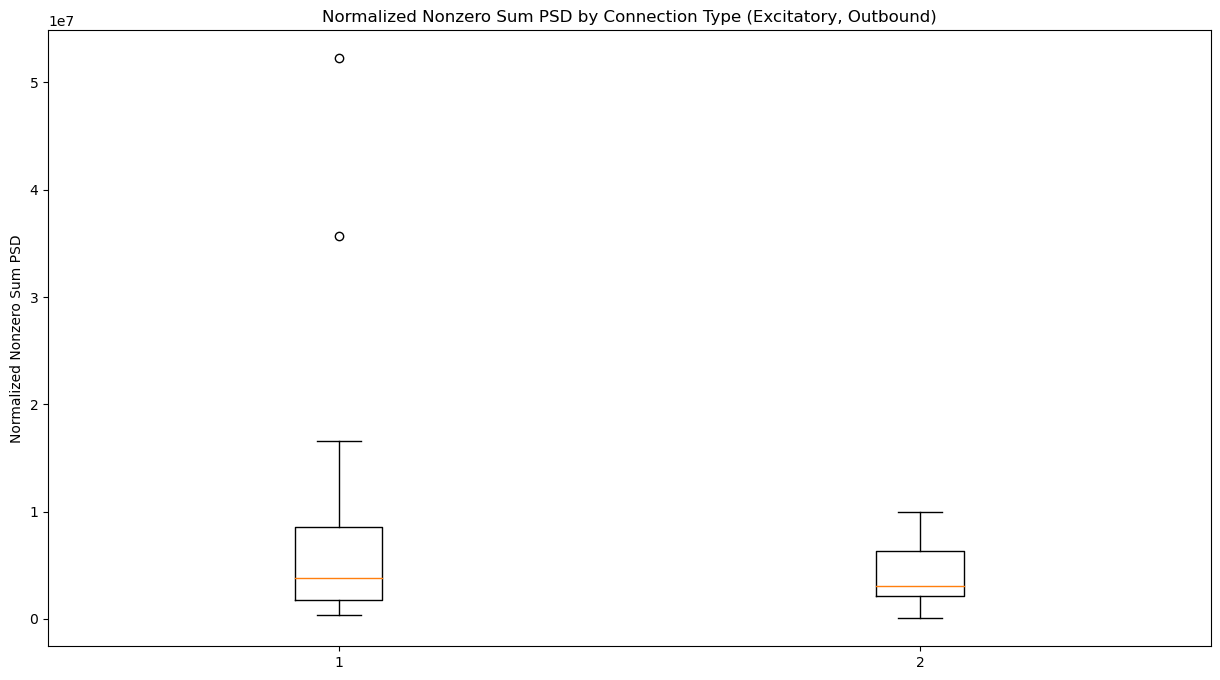

Wilcoxon Signed-Rank Test (Matched Pairs) for Normalized Nonzero Sum PSD (Excitatory, Outbound)
Test Statistic: 293.0 p-value: 0.11032337881624699
Wilcoxon Rank-Sum Test (Unmatched Data) for Normalized Nonzero Sum PSD (Excitatory, Outbound)
Test Statistic: 1.3411370730274548 p-value: 0.08993797627996997


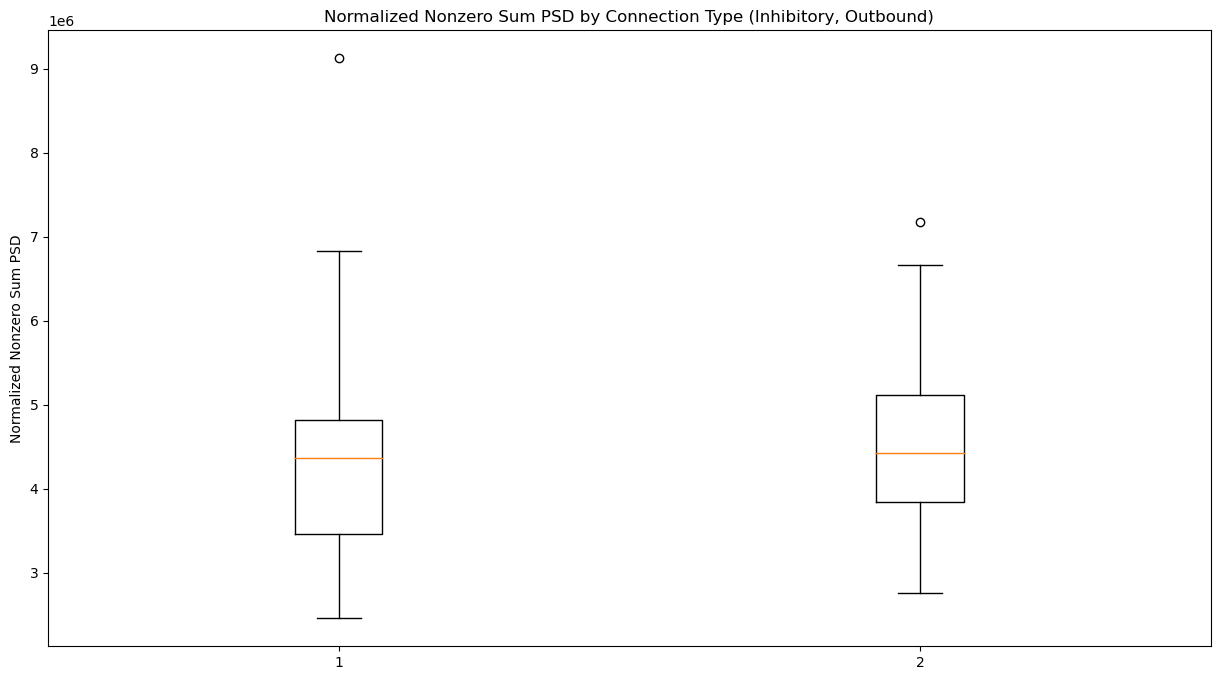

Wilcoxon Signed-Rank Test (Matched Pairs) for Normalized Nonzero Sum PSD (Inhibitory, Outbound)
Test Statistic: 298.0 p-value: 0.9575781013013511
Wilcoxon Rank-Sum Test (Unmatched Data) for Normalized Nonzero Sum PSD (Inhibitory, Outbound)
Test Statistic: -0.5234929895230153 p-value: 0.6996843858393493


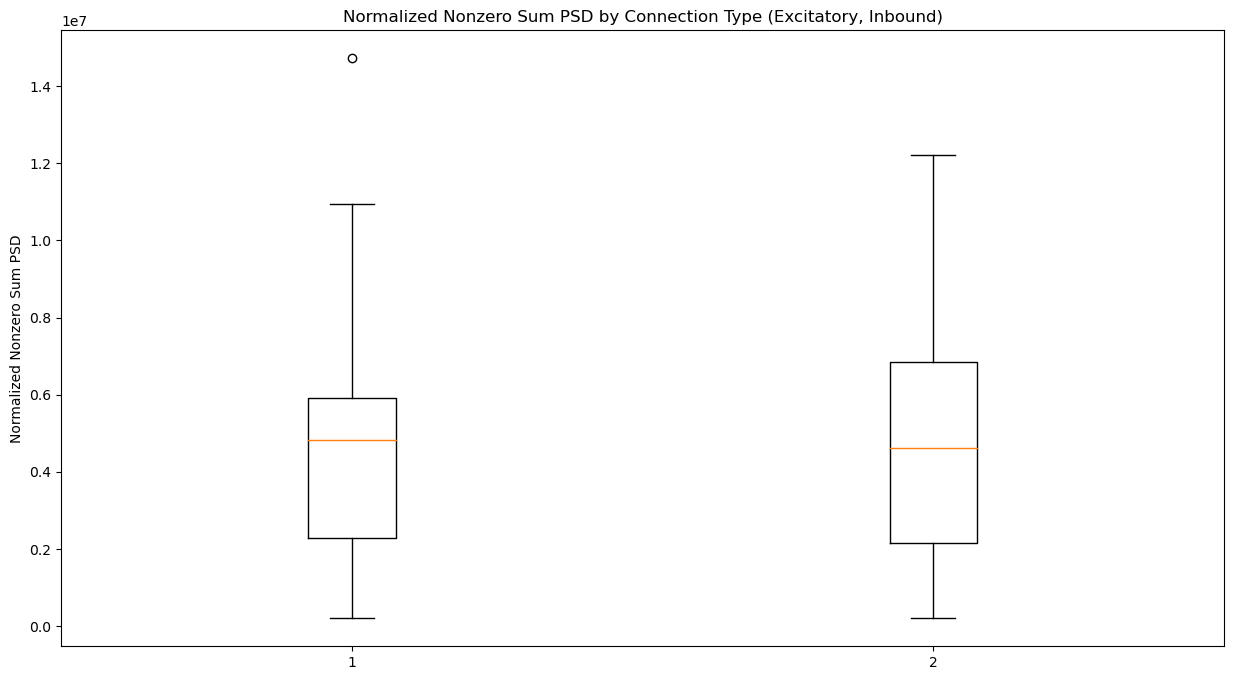

Wilcoxon Signed-Rank Test (Matched Pairs) for Normalized Nonzero Sum PSD (Excitatory, Inbound)
Test Statistic: 196.0 p-value: 0.5667461082339287
Wilcoxon Rank-Sum Test (Unmatched Data) for Normalized Nonzero Sum PSD (Excitatory, Inbound)
Test Statistic: 0.22780124699975274 p-value: 0.4099003786083848


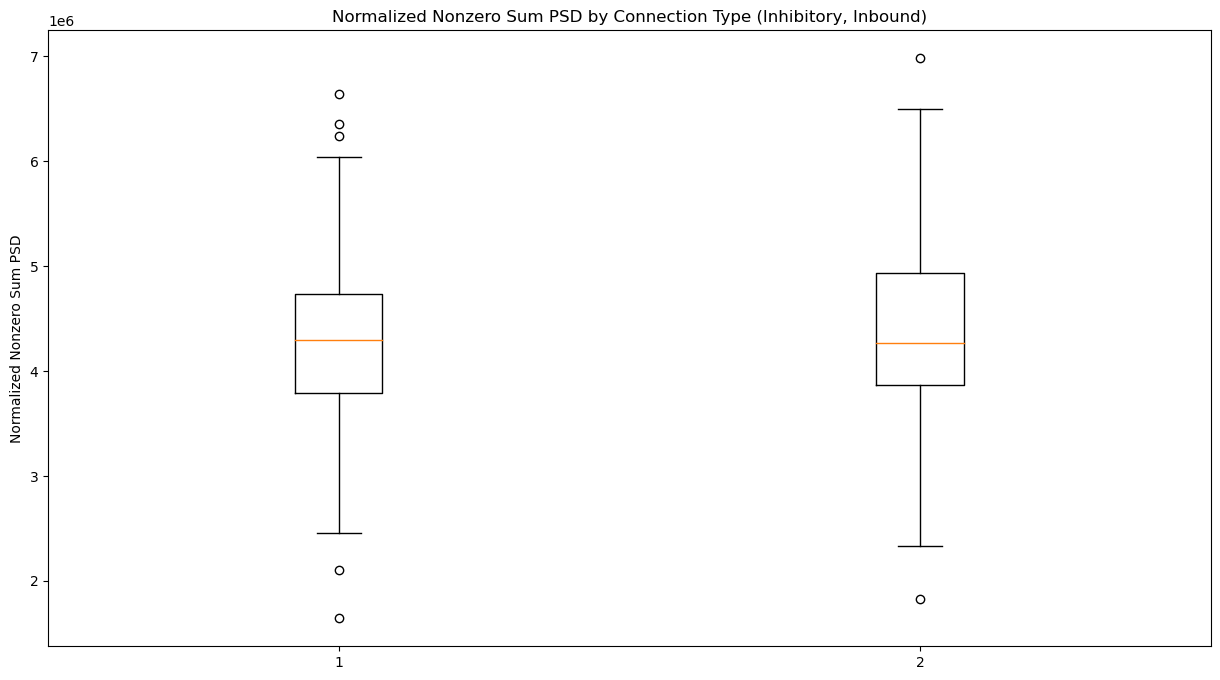

Wilcoxon Signed-Rank Test (Matched Pairs) for Normalized Nonzero Sum PSD (Inhibitory, Inbound)
Test Statistic: 245.0 p-value: 0.9925933185013491
Wilcoxon Rank-Sum Test (Unmatched Data) for Normalized Nonzero Sum PSD (Inhibitory, Inbound)
Test Statistic: -0.5682359800805379 p-value: 0.7150626283661248


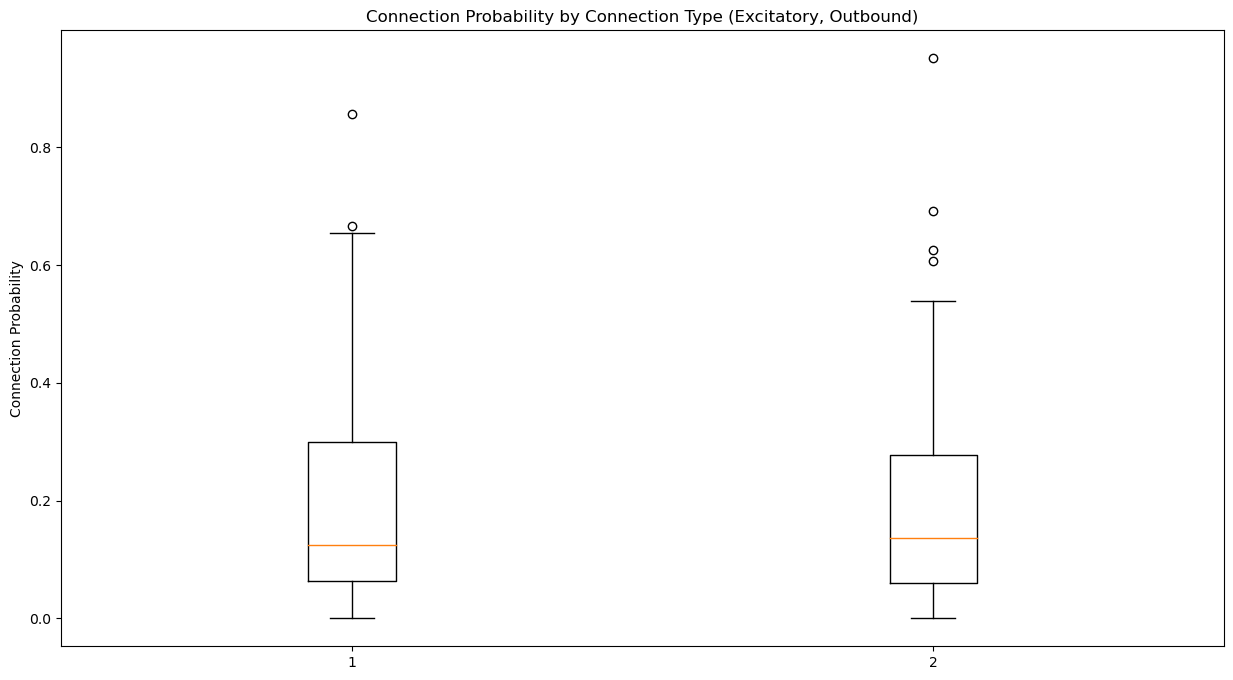

Wilcoxon Signed-Rank Test (Matched Pairs) for Connection Probability (Excitatory, Outbound)
Test Statistic: 414.0 p-value: 0.4785608803212824
Wilcoxon Rank-Sum Test (Unmatched Data) for Connection Probability (Excitatory, Outbound)
Test Statistic: -0.21924065373186108 p-value: 0.5867687056855773


c:\Users\saika\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


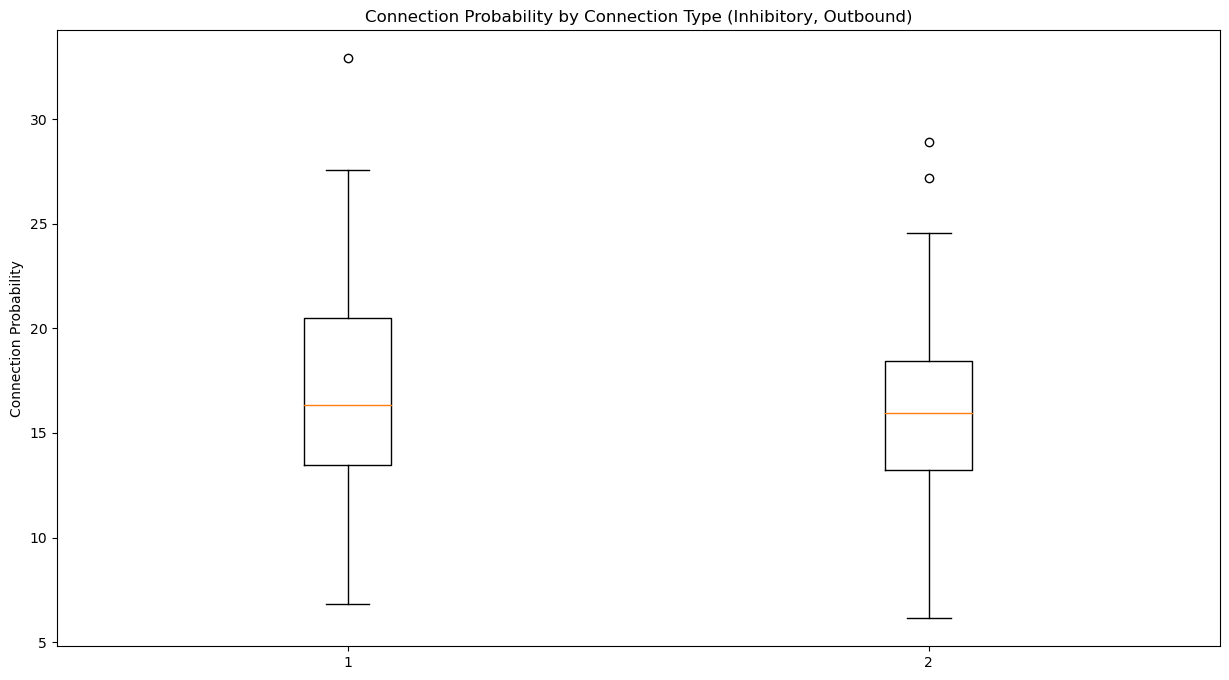

Wilcoxon Signed-Rank Test (Matched Pairs) for Connection Probability (Inhibitory, Outbound)
Test Statistic: 702.0 p-value: 0.00012810193493351107
Wilcoxon Rank-Sum Test (Unmatched Data) for Connection Probability (Inhibitory, Outbound)
Test Statistic: 0.9127570073734625 p-value: 0.18068517713644344


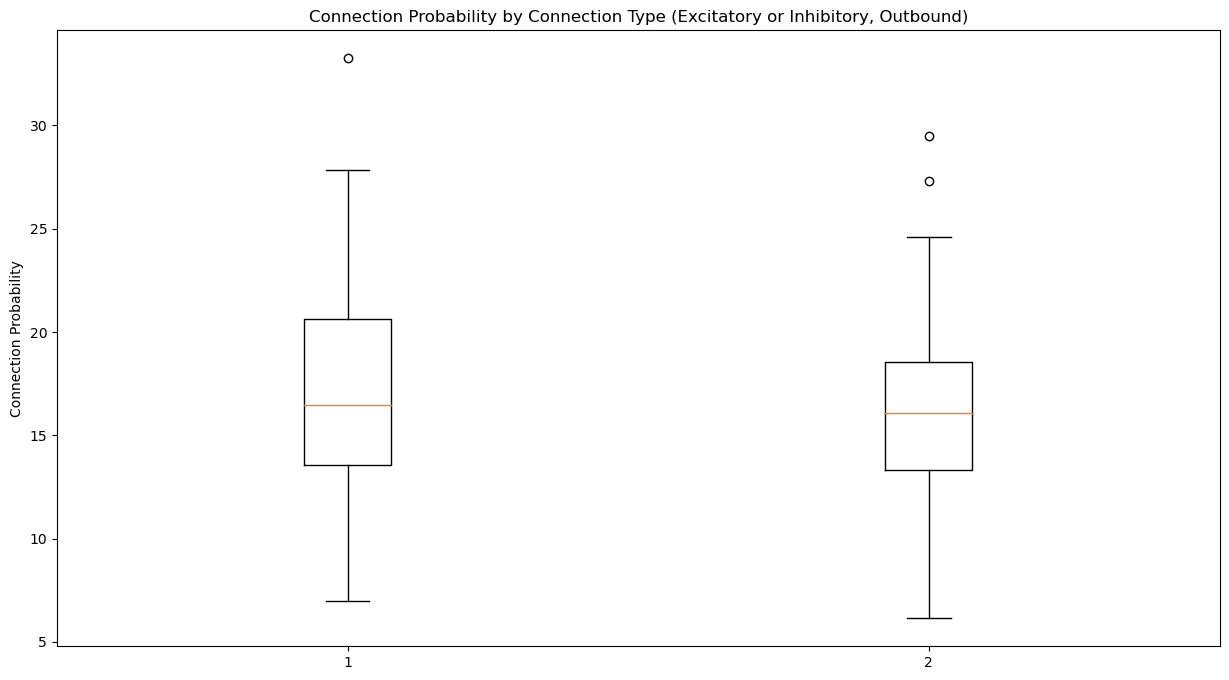

Wilcoxon Signed-Rank Test (Matched Pairs) for Connection Probability (Excitatory or Inhibitory, Outbound)
Test Statistic: 704.0 p-value: 0.00011375993472029222
Wilcoxon Rank-Sum Test (Unmatched Data) for Connection Probability (Excitatory or Inhibitory, Outbound)
Test Statistic: 0.9440771007637284 p-value: 0.17256512509101768


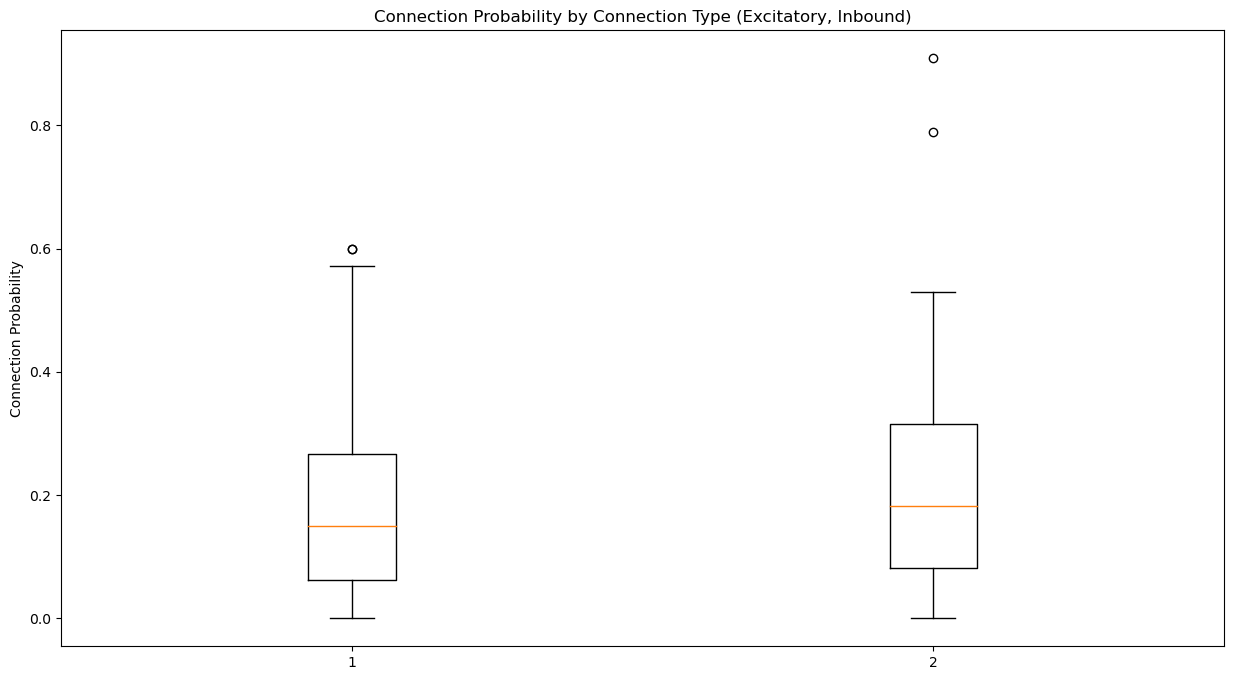

Wilcoxon Signed-Rank Test (Matched Pairs) for Connection Probability (Excitatory, Inbound)
Test Statistic: 300.0 p-value: 0.8467066581789504
Wilcoxon Rank-Sum Test (Unmatched Data) for Connection Probability (Excitatory, Inbound)
Test Statistic: -0.653247662139831 p-value: 0.7432016861274695


c:\Users\saika\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


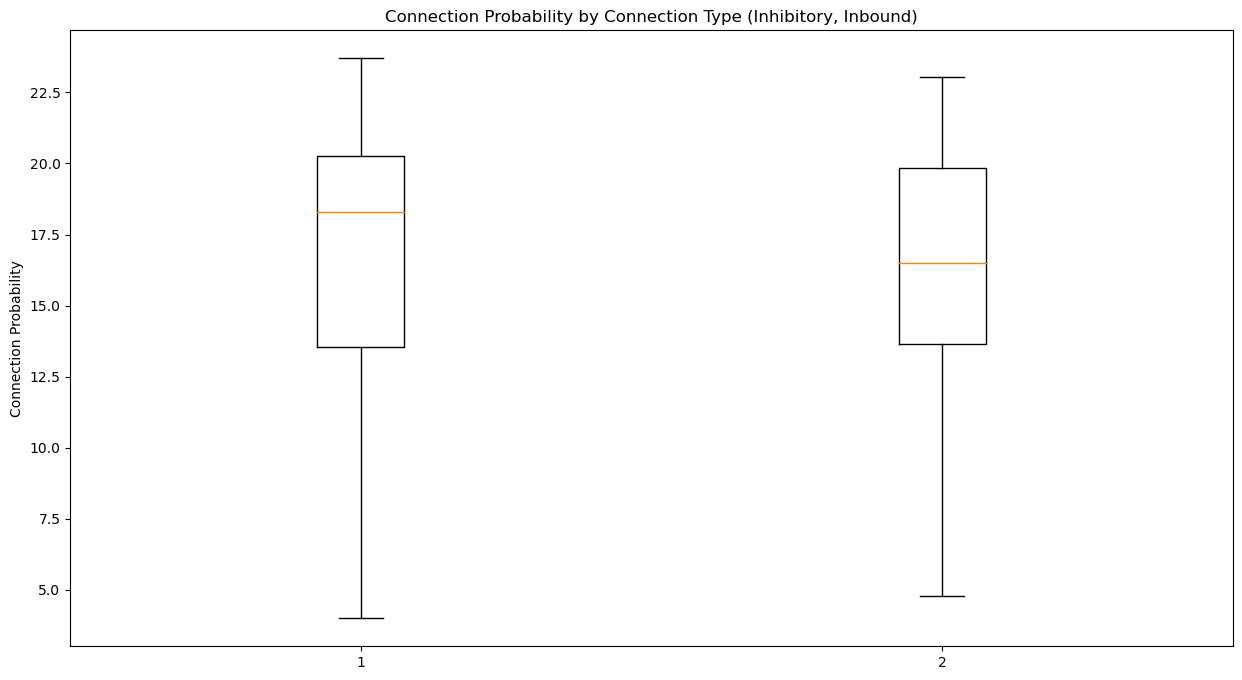

c:\Users\saika\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon Signed-Rank Test (Matched Pairs) for Connection Probability (Inhibitory, Inbound)
Test Statistic: 426.0 p-value: 0.4148599747084314
Wilcoxon Rank-Sum Test (Unmatched Data) for Connection Probability (Inhibitory, Inbound)
Test Statistic: 0.3668925225716859 p-value: 0.35684959461722426


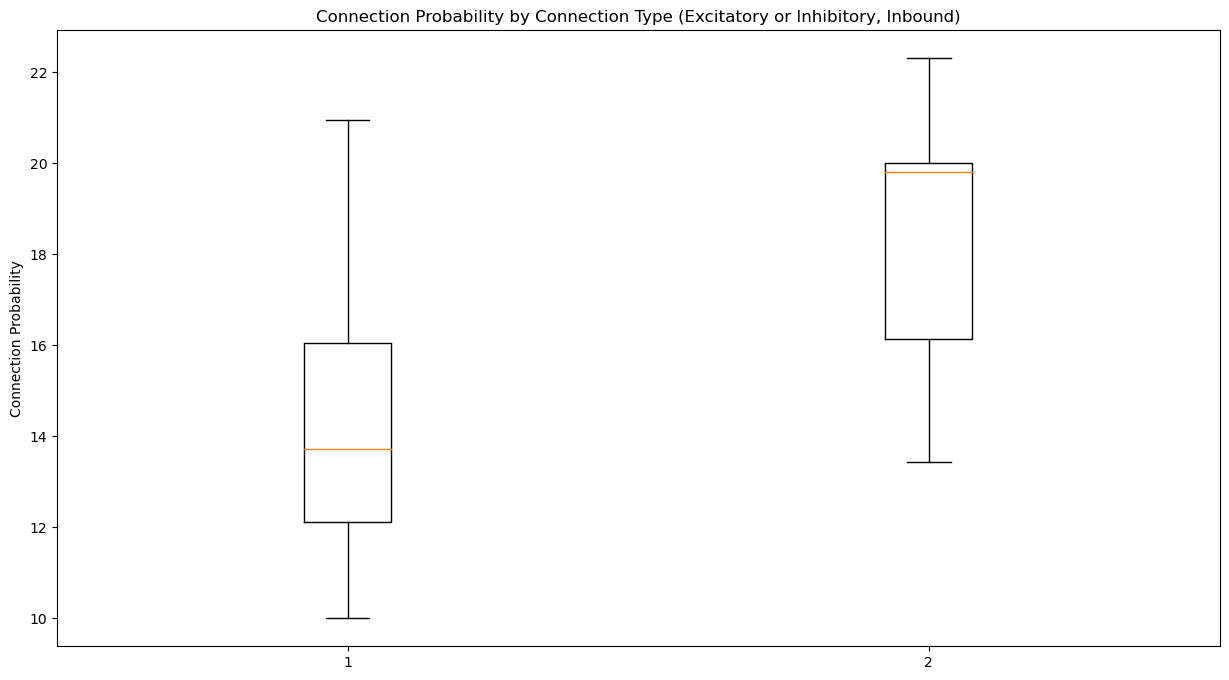

Wilcoxon Signed-Rank Test (Matched Pairs) for Connection Probability (Excitatory or Inhibitory, Inbound)
Test Statistic: 3.0 p-value: 0.25
Wilcoxon Rank-Sum Test (Unmatched Data) for Connection Probability (Excitatory or Inhibitory, Inbound)
Test Statistic: -1.5921683328090657 p-value: 0.9443265567334298


In [11]:
def signed_rank_rank_sum(shared_data, disjoint_data, metric_name, chain_type, direction):
    """
    Perform Wilcoxon signed-rank test for matched pairs and Wilcoxon rank-sum test for unmatched data.
    Outputs box plots and test results for each metric, chain type, and direction.
    
    Parameters:
    shared_data (dict): Metric values for cells in the shared set.
    disjoint_data (dict): Metric values for cells in the disjoint set.
    metric_name (str): Name of the metric (e.g., 'Normalized Nonzero Sum PSD', 'Connection Probability').
    chain_type (str): Type of chain ('Excitatory' or 'Inhibitory').
    direction (str): Direction of activity ('Inbound' or 'Outbound').

    """
    # Extract shared and disjoint values
    shared_values = list(shared_data.values())
    disjoint_values = list(disjoint_data.values())

    # Find common cells for matched pairs analysis
    common_cells = set(shared_data.keys()) & set(disjoint_data.keys())
    shared_matched = [shared_data[cell] for cell in common_cells]
    disjoint_matched = [disjoint_data[cell] for cell in common_cells]

    # Plot data
    plt.figure(figsize=(15,8))
    plt.boxplot([shared_values, disjoint_values])
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} by Connection Type ({chain_type}, {direction})")
    plt.show()

    # Perform Wilcoxon signed-rank test for matched pairs
    if common_cells:
        signed_rank_result = wilcoxon(shared_matched, disjoint_matched, alternative='greater')
        print(f"Wilcoxon Signed-Rank Test (Matched Pairs) for {metric_name} ({chain_type}, {direction})")
        print("Test Statistic:", signed_rank_result.statistic, "p-value:", signed_rank_result.pvalue)

    # Perform Wilcoxon rank-sum test for unmatched data
    rank_sum_result = ranksums(shared_values, disjoint_values, alternative='greater')
    print(f"Wilcoxon Rank-Sum Test (Unmatched Data) for {metric_name} ({chain_type}, {direction})")
    print("Test Statistic:", rank_sum_result.statistic, "p-value:", rank_sum_result.pvalue)

signed_rank_rank_sum(
    shared_data=W_nonzero_chain_out_excitatory['shared'],
    disjoint_data=W_nonzero_chain_out_excitatory['disjoint'],
    metric_name="Normalized Nonzero Sum PSD",
    chain_type="Excitatory",
    direction="Outbound"
)

signed_rank_rank_sum(
    shared_data=W_nonzero_chain_out_inhibitory['shared'],
    disjoint_data=W_nonzero_chain_out_inhibitory['disjoint'],
    metric_name="Normalized Nonzero Sum PSD",
    chain_type="Inhibitory",
    direction="Outbound"
)

# Inbound Normalized Nonzero Sum PSD
signed_rank_rank_sum(
    shared_data=W_nonzero_chain_in_excitatory['shared'],
    disjoint_data=W_nonzero_chain_in_excitatory['disjoint'],
    metric_name="Normalized Nonzero Sum PSD",
    chain_type="Excitatory",
    direction="Inbound"
)

signed_rank_rank_sum(
    shared_data=W_nonzero_chain_in_inhibitory['shared'],
    disjoint_data=W_nonzero_chain_in_inhibitory['disjoint'],
    metric_name="Normalized Nonzero Sum PSD",
    chain_type="Inhibitory",
    direction="Inbound"
)

# Outbound Probability of Connection
signed_rank_rank_sum(
    shared_data=B_chain_out_excitatory['shared'],
    disjoint_data=B_chain_out_excitatory['disjoint'],
    metric_name="Connection Probability",
    chain_type="Excitatory",
    direction="Outbound"
)

signed_rank_rank_sum(
    shared_data=B_chain_out_inhibitory['shared'],
    disjoint_data=B_chain_out_inhibitory['disjoint'],
    metric_name="Connection Probability",
    chain_type="Inhibitory",
    direction="Outbound"
)

signed_rank_rank_sum(
    shared_data=B_chain_out['shared'],
    disjoint_data=B_chain_out['disjoint'],
    metric_name="Connection Probability",
    chain_type="Excitatory or Inhibitory",
    direction="Outbound"
)
# Inbound Probability of Connection
signed_rank_rank_sum(
    shared_data=B_chain_in_excitatory['shared'],
    disjoint_data=B_chain_in_excitatory['disjoint'],
    metric_name="Connection Probability",
    chain_type="Excitatory",
    direction="Inbound"
)

signed_rank_rank_sum(
    shared_data=B_chain_in_inhibitory['shared'],
    disjoint_data=B_chain_in_inhibitory['disjoint'],
    metric_name="Connection Probability",
    chain_type="Inhibitory",
    direction="Inbound"
)

signed_rank_rank_sum(
    shared_data=B_chain_in['shared'],
    disjoint_data=B_chain_in['disjoint'],
    metric_name="Connection Probability",
    chain_type="Excitatory or Inhibitory",
    direction="Inbound"
)